In [81]:
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = Path("iq_int16.pcm")  


def read_iq_int16(path: Path, normalize: bool = True) -> np.ndarray:
    """Читает int16 IQ-файл и возвращает комплексный массив."""
    raw = np.fromfile(path, dtype=np.int16)
    if raw.size < 2:
        raise ValueError("Файл должен содержать хотя бы одну пару I/Q отсчётов.")
    if raw.size % 2:
        raw = raw[:-1]
    i = raw[0::2].astype(np.float32)
    q = raw[1::2].astype(np.float32)
    iq = i + 1j * q
    if normalize:
        peak = np.max(np.abs(iq))
        if peak > 0:
            iq = iq / peak
    return iq.astype(np.complex64)



In [82]:
try:
    iq_samples = read_iq_int16(DATA_PATH)
    print(f"Загружено {iq_samples.size} комплексных отсчётов из {DATA_PATH.name}")
    print(f"Пример первых 5 отсчётов: {iq_samples[:5]}")
except FileNotFoundError:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Файл {DATA_PATH} не найден. Укажите корректный путь в переменной DATA_PATH.")
except Exception as exc:
    iq_samples = np.array([], dtype=np.complex64)
    print(f"Ошибка при чтении: {exc}")



Загружено 100000 комплексных отсчётов из iq_int16.pcm
Пример первых 5 отсчётов: [ 0.24574143-0.77171683j -0.23794125+0.23271728j  0.10905939+0.09031033j
  0.2526113 -0.72391385j -0.37269112-0.13682516j]


In [ ]:
# def estimate_f_rel(signal: np.ndarray) -> float:
#     """Оценивает относительное смещение частоты по средней фазовой скорости."""
#     if signal.size < 2:
#         return 0.0
#     diffs = np.angle(signal[1:] * np.conj(signal[:-1]))
#     mean_phase = np.mean(diffs)
#     f_rel_est = float(mean_phase / (2 * np.pi))
#     if not np.isfinite(f_rel_est):
#         return 0.0
#     return f_rel_est



In [ ]:
# if iq_samples.size:
#     f_rel_est = estimate_f_rel(iq_samples)
#     print(f"Оценённое f_rel: {f_rel_est:+.6f}")
# else:
#     f_rel_est = 0.0
#     print("Нет данных для оценки f_rel.")



Оценённое f_rel: -0.001016


In [ ]:
def estimate_f_rel_spectrum(signal: np.ndarray, n_fft: int = 131072) -> float:
    """Оценивает f_rel через поиск пика мощности в спектре."""
    if signal.size < 2:
        return 0.0
    length = min(signal.size, n_fft)
    segment = signal[:length]
    window = np.hanning(length)
    weighted = segment * window
    spectrum = np.fft.fftshift(np.fft.fft(weighted, n=length))
    freqs = np.fft.fftshift(np.fft.fftfreq(length, d=1.0))
    peak_idx = int(np.argmax(np.abs(spectrum)))
    return float(freqs[peak_idx])



In [ ]:
def estimate_f_rel_autocorr(signal: np.ndarray, lag: int = 16) -> float:
    """Оценивает f_rel по фазе автокорреляции на заданном лаге."""
    if signal.size <= lag:
        return 0.0
    segment = signal[lag:] * np.conj(signal[:-lag])
    corr = np.mean(segment)
    return float(np.angle(corr) / (2 * np.pi * lag))



In [86]:
if iq_samples.size:
    f_rel_spec = estimate_f_rel_spectrum(iq_samples)
    print(f"Спектральная оценка f_rel: {f_rel_spec:+.6f}")
    print(f"Разница со средней фазой: {f_rel_spec - f_rel_est:+.6e}")
else:
    f_rel_spec = 0.0
    print("Нет данных для спектральной оценки f_rel.")



Спектральная оценка f_rel: +0.175250
Разница со средней фазой: +1.762661e-01


In [90]:
if iq_samples.size:
    f_rel_corr = estimate_f_rel_autocorr(iq_samples)
    print(f"Автокорреляционная оценка f_rel: {f_rel_corr:+.6f}")
    print(f"Разница со средней фазой: {f_rel_corr - f_rel_est:+.6e}")
else:
    f_rel_corr = 0.0
    print("Нет данных для автокорреляционной оценки f_rel.")



Автокорреляционная оценка f_rel: -0.011795
Разница со средней фазой: -1.077911e-02


In [ ]:

f_rel = -0.00026

if iq_samples.size and not np.isclose(f_rel, 0.0):
    n = np.arange(iq_samples.size, dtype=np.float32)
    iq_baseband = iq_samples * np.exp(-1j * 2 * np.pi * f_rel * n)
    print("Компенсация по оценённому f_rel выполнена.")
else:
    iq_baseband = iq_samples.copy()
    print("Компенсация не выполнялась (f_rel≈0 или нет данных).")



Компенсация по оценённому f_rel выполнена.


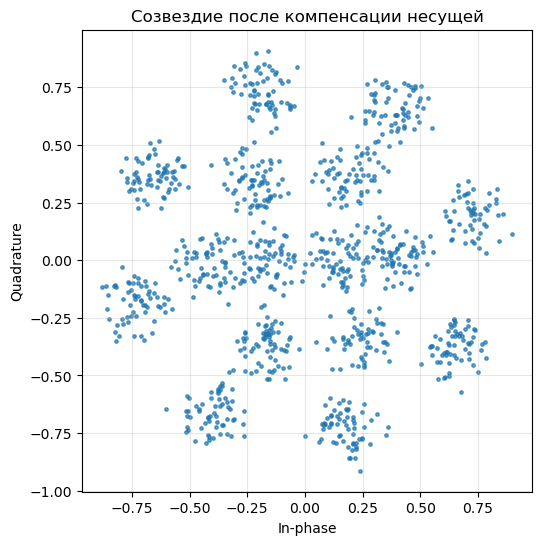

In [96]:
MAX_POINTS = 1000

points = iq_baseband[:MAX_POINTS] if iq_baseband.size else np.array([], dtype=np.complex64)

if points.size:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(points.real, points.imag, s=6, alpha=0.7)
    ax.set_title("Созвездие после компенсации несущей")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", "box")
    plt.show()
else:
    print("Нет данных для отображения. Запустите предыдущие ячейки.")

